# Introduction

This notebook demostrates the prediction pipeline for the trained classifiers. With the 3 pretrained classifiers, you can easily classify a new structure that is not included in the original training set.

**Note**: 
- For easier readability, you can change the fontsize of this notebook by navigating to `Settings` -> `JupyterLab Theme` and increasing or decreasing the fontsize from the dropdown menu.
- For first-time JupyterLab users, you can use your mouse to select and run individual code cell by pressing <kbd>⇧ Shift</kbd> + <kbd>↩ Return</kbd> (it is recommended that you run the cells in order).
- To run all the cells, you can navigate to `Run` -> `Run All Cells`. You can also clear all outputs and rerun all cells by clicking on ▶▶. 
- To properly display the progress bar (you may see it as `HBox`) and the Plotly interactive figure, you need to run all the cells first!

# Import packages and functions

In [1]:
import sys
# force the notebook to look for files in the upper level directory
sys.path.insert(1, '../')

In [2]:
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
from glob import glob
from tqdm import tqdm
import plotly.express as px
import matplotlib.pyplot as plt
from IPython.display import IFrame
from sklearn.impute import KNNImputer
from model.model_building import load_data
from data.data_cleaning import abbreviate_features
from data.compound_featurizer import read_new_struct, composition_featurizer, structure_featurizer, handbuilt_featurizer

# Set up constants
The `REDUCED_PATH` contains the reduced feature set used to train the classifiers. The `FULL_PATH` contains the full feature set used to impute missing values in the uploaded new structure should there be any. In terms of the number of predictors, the reduced feature dataset is a subset of the full feature dataset, with features selected according to SHAP feature importance and domain knowledge.

The `NEW_STRUCT_PATH` contains the demo CIF structure file and you can _**test your own structure**_ by uploading the CIF file to the "user_defined_structures" folder and changing the `NEW_STRUCT_PATH`. You can save time by pressing <kbd>⇥ Tab</kbd> for auto-completion after typing the first few words.

**Note**: If you choose to upload your own cif structure file, it is preferable that the structure already has an oxidation state assigned to each site. If not, the featurizer will try to guess the oxidation states using the [oxi_state_guesses()](https://pymatgen.org/pymatgen.core.composition.html?highlight=oxi_state_guesses#pymatgen.core.composition.Composition.oxi_state_guesses) function from Pymatgen. There is no guarantee that the guessed oxidation states will be correct and the script will also ask for user input if it is unable to guess the oxidation states. In addition, the uploaded structure has to have at least **2 different elements** (i.e., at least a binary compound). A single element structure such as Si will lead to an error in the script.

There are 3 demo structures: CuNiO$_2$, Ca2CoN$_2$ and Ga(MoSe$_2$)$_4$ for you to try out and they are not present in the [training database](../data/processed/csv_version/IMT_Classification_Dataset_Reduced_Feature_Set_v10.csv).

In [3]:
REDUCED_PATH = "../data/processed/IMT_Classification_Dataset_Reduced_Feature_Set_v10.xlsx"
FULL_PATH = "../data/processed/IMT_Classification_Dataset_Full_Feature_Set_v10.xlsx"
NEW_STRUCT_PATH = "./user_defined_structures/CuNiO2_mp-1178372_primitive.cif"

# Define some helper functions

In [4]:
def assign_oxi_state(elem_symbol):
    """Allow the user to assign oxidation state to each element."""
    oxi_state = input("{}:".format(elem_symbol))
    return float(oxi_state)


def check_all_zero_oxi_state(structure):
    """Check if all the oxidation states in the structure are all zero"""
    try:
        # get all the oxidation states by specie
        oxi_states = [specie.oxi_state for specie in structure.composition.elements]
    except AttributeError:
        # if there are no species but elements present, then return True
        return True
    
    # if the species all have zero oxidation state, also return True
    if np.sum(np.array(oxi_states) == 0) == len(oxi_states):
        return True
    return False


def check_oxi_state(structure):
    """Check if the structure has no oxidation states assigned and the guessed oxidation states are all zero. If so, trigger user input."""
    if (check_all_zero_oxi_state(structure)) and (not structure.composition.oxi_state_guesses()):
        # get all the elements in the input structure
        elem_lst = [element.symbol for element in structure.composition.element_composition.elements]
        # get the reduced formula
        reduced_formula = structure.composition.reduced_formula
        print("Unable to guess oxidation states for {}. Please manually assign oxidation states by element".format(reduced_formula))
        # get a dictionary to overwrite the default guessed oxidation states
        elem_oxi_states = {elem_symbol: [assign_oxi_state(elem_symbol)] for elem_symbol in elem_lst}
        return elem_oxi_states
    return None


def featurizer_wrapper(df_input):
    """A wrapper function around the composition, structure and handbuilt featurizers."""
    # get the structure from the initialized dataframe
    new_struct = df_input.at[0, "structure"]
    # check if the guessed oxidation states are all zeros and allow user-overwrite if true
    oxi_states_by_element = check_oxi_state(new_struct.get_primitive_structure())
    # featurize the given structure using 3 predefined featurizers
    df_output = composition_featurizer(df_input, oxi_states_override=oxi_states_by_element)
    df_output = structure_featurizer(df_output, oxi_states_override=oxi_states_by_element)
    df_output = handbuilt_featurizer(df_output)
    return df_output


def process_new_struct_df(df_new, df_full_set):
    """Process the newly featurized structure(s) and impute any missing values with KNNImputer"""
    new_struct_df_with_name = abbreviate_features(df_new)
    # check if the dataframe contains missing values: if not, then return immediately
    if new_struct_df_with_name.isna().sum(axis=1).sum() == 0:
        return new_struct_df_with_name.drop(columns="Compound"), new_struct_df_with_name
    # select the same features as the full feature set
    new_struct_df = new_struct_df_with_name.filter(items=df_full_set.columns).drop(columns="Compound")
    # combine the full feature set with the new structure's features
    df_with_new_struct = pd.concat([df_full_set.drop(columns=["Compound", "Label", "struct_file_path"]), 
                                    new_struct_df], ignore_index=True)
    
    # impute the missing values with the values from the 5 nearest neighbors 
    # weighted by their distances to the new structures' non-missing values
    knn_imputer = KNNImputer(n_neighbors=5, weights="distance")
    # get the imputed dataframe for the new structure
    new_struct_df_imputed = knn_imputer.fit_transform(df_with_new_struct)[-df_new.shape[0]:]
    # add back the column names
    new_struct_df = pd.DataFrame(new_struct_df_imputed, columns=new_struct_df.columns)
    # get the new structure name and create a copy of new_struct_df with the compound name
    new_struct_name = new_struct_df_with_name["Compound"].to_list()
    new_struct_df_with_name = new_struct_df.copy()
    new_struct_df_with_name["Compound"] = new_struct_name
    return new_struct_df, new_struct_df_with_name

# Read in the reduced dataset

This is a quick overview of the training dataset. It will be used later on to select the relevant features from the raw output of the featurizer.

In [5]:
df = pd.read_excel(REDUCED_PATH)
df

,Compound,Label,struct_file_path,gii,est_hubbard_u,est_charge_trans,ewald_energy_per_atom,avg_dev_Electronegativity,range_MendeleevNumber,avg_dev_CovalentRadius,avg_mm_dists,avg_mx_dists,avg_xx_dists
0,Ba(FeSb3)4,0,../data/Structures/Metals/BaFe4Sb12_CollCode_6...,0.000000,21.129322,19.461062,-12.916613,0.169412,76,8.608997,4.601000,2.596481,3.266718
1,Ba(NiP)2,0,../data/Structures/Metals/BaNi2P2_SD_1701656.cif,1.080042,11.858755,35.445979,-29.022094,0.371200,74,31.840000,2.790950,2.259574,3.631725
2,Ba(PIr)2,0,../data/Structures/Metals/BaIr2P2_CollCode_957...,3.015802,5.839285,34.042180,-27.929343,0.417600,74,29.120000,2.790243,2.355169,3.754372
3,Ba(PRh)2,0,../data/Structures/Metals/BaRh2P2_CollCode_501...,1.337935,7.810114,33.195560,-28.030653,0.430400,74,28.960000,2.785294,2.346291,3.757078
4,Ba(Sb3Os)4,0,../data/Structures/Metals/BaOs4Sb12_CollCode_6...,1.037038,12.916563,10.425355,-12.725768,0.132595,76,8.276817,4.670000,2.635420,3.315708
...,...,...,...,...,...,...,...,...,...,...,...,...,...
338,VO2,2,../data/Structures/MIT_materials/HighT/VO2_HT_...,0.128538,14.484546,9.779242,-47.781257,0.804444,41,38.666667,3.522330,1.927294,2.675472
339,YCoO3,2,../data/Structures/MIT_materials/HighT/YCoO3_C...,0.188213,13.895560,12.815560,-34.679490,0.907200,75,44.160000,3.716576,1.933264,2.881036
340,YFe4(CuO4)3,2,../data/Structures/MIT_materials/HighT/YCu3Fe4...,0.188611,12.807177,16.608178,-37.225832,0.796800,75,35.160000,3.653850,2.356918,2.745188
341,YNiO3,2,../data/Structures/MIT_materials/HighT/YNiO3_6...,0.231001,15.898371,10.393278,-34.202393,0.900000,75,43.680000,3.755161,1.963601,2.827539


As we can see here, the reduced dataset used for training the classifier has 343 unique compounds and 13 columns. Excluding `Compound`, `Label` and `struct_file_path`, there are 10 features used for prediction (i.e., 10 predictors).

# Make a prediction on a never-before-seen structure

## 1. Load the three trained models

In [6]:
# load the metal vs. non_metal classifier
metal_model = xgb.XGBClassifier()
metal_model.load_model("../model/saved_models/new_models/metal_reduced.model")

# load the insulator vs. non_insulator classifier
insulator_model = xgb.XGBClassifier()
insulator_model.load_model("../model/saved_models/new_models/insulator_reduced.model")

# load the mit vs. non_mit classifier
mit_model = xgb.XGBClassifier()
mit_model.load_model("../model/saved_models/new_models/mit_reduced.model")

## 2. Read in and featurize the new structure
If you find the featurization process to be slow, please set the `supercell_matrix` argument to <span style="background-color:yellow">None</span>.

In [7]:
new_struct_df = read_new_struct(NEW_STRUCT_PATH, supercell_matrix=[2, 2, 2])
new_struct_df = featurizer_wrapper(new_struct_df)

/Users/jasonrpw/PycharmProjects/mit_model_code/venv/lib/python3.7/site-packages/tqdm/std.py:670: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


Here is the raw output from the featurizer.

In [8]:
new_struct_df

,Compound,structure,composition,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,MagpieData avg_dev Number,MagpieData mode Number,MagpieData minimum MendeleevNumber,...,max_xx_dists,min_xx_dists,avg_xx_dists,v_m,v_x,iv,iv_p1,est_hubbard_u,est_charge_trans,volume_per_site
0,CuNiO2,"[[0. 0. 0.] Cu, [0. 0. 5.69675...","(Cu, Ni, O)",8.0,29.0,21.0,18.25,10.25,8.0,61.0,...,3.678072,2.77446,3.099888,-24.969425,23.63686,18.168838,35.187,12.249891,15.8569,9.840079


## 3. Only select predictors that are in the reduced feature set

We need to load in the full feature set to help impute the missing values in the newly featurized structure, should there be any. The imputing process utilizes the [KNNImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html) from scikit-learn.

In [9]:
df_full = pd.read_excel(FULL_PATH)
df_full

,Compound,Label,struct_file_path,range_MendeleevNumber,mean_MendeleevNumber,avg_dev_MendeleevNumber,maximum_AtomicWeight,range_AtomicWeight,mean_AtomicWeight,avg_dev_AtomicWeight,...,avg_mx_dists,max_xx_dists,min_xx_dists,avg_xx_dists,v_m,v_x,iv_p1,est_hubbard_u,est_charge_trans,volume_per_site
0,Ba(FeSb3)4,0,../data/Structures/Metals/BaFe4Sb12_CollCode_6...,76,73.470588,16.276817,137.32700,81.482000,107.166294,24.151197,...,2.596481,3.450762,2.871024,3.266718,-23.735803,9.622199,54.91000,21.129322,19.461062,22.917528
1,Ba(NiP)2,0,../data/Structures/Metals/BaNi2P2_SD_1701656.cif,74,59.400000,20.160000,137.32700,106.353238,63.332265,29.597894,...,2.259574,3.709116,3.554335,3.631725,-22.390084,28.414957,35.18700,11.858755,35.445979,18.414152
2,Ba(PIr)2,0,../data/Structures/Metals/BaIr2P2_CollCode_957...,74,59.000000,20.000000,192.21700,161.243238,116.741705,68.614354,...,2.355169,3.794974,3.713769,3.754372,-20.210211,27.763527,28.00000,5.839285,34.042180,19.575756
3,Ba(PRh)2,0,../data/Structures/Metals/BaRh2P2_CollCode_501...,74,58.600000,19.840000,137.32700,106.353238,81.017105,40.034674,...,2.346291,3.776568,3.737587,3.757078,-20.397126,27.833127,31.06000,7.810114,33.195560,19.512571
4,Ba(Sb3Os)4,0,../data/Structures/Metals/BaOs4Sb12_CollCode_6...,76,73.941176,15.612457,190.23000,68.470000,138.786294,24.208803,...,2.635420,3.502512,2.914080,3.315708,-23.385103,9.480030,41.00000,12.916563,10.425355,23.964132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338,VO2,2,../data/Structures/MIT_materials/HighT/VO2_HT_...,41,73.333333,18.222222,50.94150,34.942100,27.646767,15.529822,...,1.927294,2.725617,2.575183,2.675472,-45.333235,26.337259,65.28165,14.484546,9.779242,9.863262
339,YCoO3,2,../data/Structures/MIT_materials/HighT/YCoO3_C...,75,66.200000,24.960000,88.90585,72.906450,39.167449,27.801659,...,1.933264,3.527817,2.699880,2.881036,-37.430821,24.043918,51.27000,13.895560,12.815560,10.252012
340,YFe4(CuO4)3,2,../data/Structures/MIT_materials/HighT/YCu3Fe4...,75,73.400000,16.320000,88.90585,72.906450,34.745832,22.495719,...,2.356918,2.896772,2.559157,2.745188,-26.680740,24.867599,37.86795,12.807177,16.608178,9.756232
341,YNiO3,2,../data/Structures/MIT_materials/HighT/YNiO3_6...,75,66.800000,24.240000,88.90585,72.906450,39.119490,27.744108,...,1.963601,3.184308,2.736503,2.827539,-36.802534,23.821848,54.92000,15.898371,10.393278,10.686816


In [10]:
new_struct_df, new_struct_df_with_name = process_new_struct_df(new_struct_df, df_full)
new_struct_df = new_struct_df.filter(items=df.columns)
new_struct_df

,gii,est_hubbard_u,est_charge_trans,ewald_energy_per_atom,avg_dev_Electronegativity,range_MendeleevNumber,avg_dev_CovalentRadius,avg_mm_dists,avg_mx_dists,avg_xx_dists
0,0.132573,12.249891,15.8569,-23.754963,0.7675,26.0,31.0,3.019889,2.096101,3.099888


Here is a printout of the number of predictors in the newly featurized structure

In [11]:
new_struct_df.shape[1]

10

Compare the number of predictors with the training data loaded into the MIT classifier

In [12]:
train_x, _ = load_data(df, "MIT")
train_x.shape[1]

10

## 4. Print out the prediction label and probability

After selecting the relevant features, we are now ready to make a prediction for the given structure. Below, you will see the outputs from the metal _vs._ non_metal, insulator _vs._ non_insulator and mit _vs._ non_mit classifiers. `1` means the structure is predicted to the positive class and `0` means it is predicted to be the negative class.

**Note**: It is possible for the classifier to classify a structure as multiple classes. (e.g., as both a metal and an MIT). We've provided you with the probability of each prediction and we'll let you be the final judge.

In [13]:
print("Is a metal: {}, and the probability of being a metal is :{:0.4f}\n".format(metal_model.predict(new_struct_df)[0], metal_model.predict_proba(new_struct_df)[0][1]))
print("Is an insulator: {}, and the probability of being an insulator is :{:0.4f}\n".format(insulator_model.predict(new_struct_df)[0], 
                                                                                    insulator_model.predict_proba(new_struct_df)[0][1]))
print("Is an mit: {}, and the probability of being an mit is :{:0.4f}".format(mit_model.predict(new_struct_df)[0], mit_model.predict_proba(new_struct_df)[0][1]))

Is a metal: 0, and the probability of being a metal is :0.1808

Is an insulator: 1, and the probability of being an insulator is :0.9908

Is an mit: 0, and the probability of being an mit is :0.0032


## 5. Plot the data using the Range of the Mendeleev Number & the Average Deviation of the Covalent Radius

These two features are identified with high feature importance for the MIT _vs._ non-MIT classifier and have been shown to separate MITs from the non-MITs quite well.

We can plot all the data points (training set + the new structure) on a 2D scatter plot of `range MendeleevNumber` vs. `avg_dev CovalentRadius`.

In [14]:
x_plot = "range_MendeleevNumber"
y_plot = "avg_dev_CovalentRadius"

In [15]:
# get the relevant columns from the training set
df_plot = df[["Compound", "Label", x_plot, y_plot]]
# get the relevant columns from the new structure dataframe
new_struct_plot = new_struct_df_with_name[["Compound", x_plot, y_plot]]
# assign "New_struct" as the new strucuture's label to distinguish it from the original training set
new_struct_plot["Label"] = "New_struct"
# combine the two datasets
combined_df_plot = pd.concat([df_plot, new_struct_plot], ignore_index=True)
# change the numeric label into string format to allow discrete color scale for plotting
combined_df_plot = combined_df_plot.replace({"Label": {0: "Metal", 1: "Insulator", 2: "MIT"}})
combined_df_plot

,Compound,Label,range_MendeleevNumber,avg_dev_CovalentRadius
0,Ba(FeSb3)4,Metal,76.0,8.608997
1,Ba(NiP)2,Metal,74.0,31.840000
2,Ba(PIr)2,Metal,74.0,29.120000
3,Ba(PRh)2,Metal,74.0,28.960000
4,Ba(Sb3Os)4,Metal,76.0,8.276817
...,...,...,...,...
339,YCoO3,MIT,75.0,44.160000
340,YFe4(CuO4)3,MIT,75.0,35.160000
341,YNiO3,MIT,75.0,43.680000
342,YbFe4(CuO4)3,MIT,48.0,34.980000


Create a scatter plot.

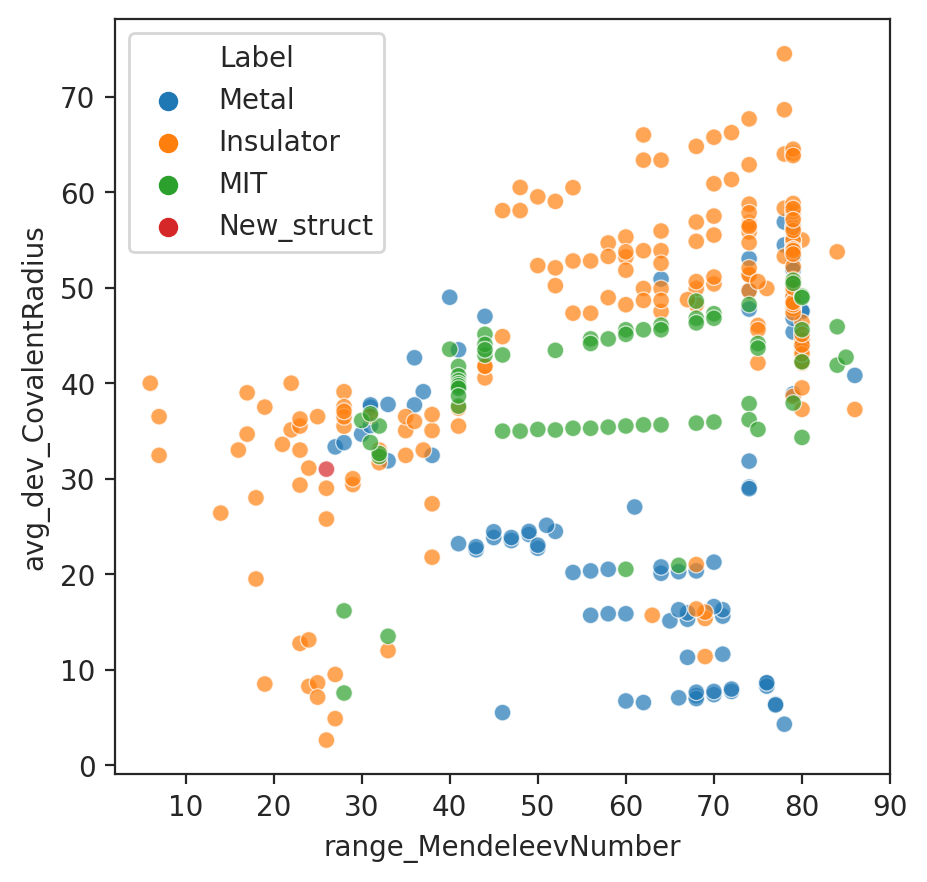

In [16]:
with sns.axes_style("ticks"):
    plt.figure(figsize=(5,5), dpi=200)
    sns.scatterplot(data=combined_df_plot, x=x_plot, y=y_plot, hue="Label", alpha=0.7)

### Here is an interactive version with Plotly

Things you can do

1. Hover your cursor over data points to display the compound name, feature values and class label.
2. Drag your cursor to zoom in on a specific region and double left click to zoom out.
3. Click once on one of the class labels on the legend to hide the points within that class.
4. Click twice on one of the class labels on the legend to show only the points within that class.

In [17]:
mendeleev_cov_radius_fig = px.scatter(combined_df_plot, x=x_plot, y=y_plot, hover_name="Compound", 
                                      height=1000, width=1000, color="Label", template="simple_white"
                                     )
mendeleev_cov_radius_fig.update_traces(mode='markers', marker_line_width=1, marker_size=10, marker_line_color="white")
mendeleev_cov_radius_fig.write_html("../plots/new_struct_mendeleev_cov_radius.html")
IFrame(src='../plots/new_struct_mendeleev_cov_radius.html', width=1100, height=1100)

## 6. Batch processing

The following section allows a user to upload a folder containing several CIFs and classify all of them at the same time.

First, specify the folder path. **If you want to upload a folder of your own and carry out the classification for all the compounds at once, all you have to do is to change the `batch_folder_path` variable.**

In [18]:
batch_folder_path = "./user_defined_structures/"

Then, get all the CIF paths and read in the structures as a dataframe.

**Note**: By default, any structure is read in as a supercell (a'=2a, b'=2b, c'=2c), which might lead to prolonged featurization time. Again, if you wish not to read in the structures as supercells or find the featurization process too slow, please specify the `supercell_matrix` argument as <span style="background-color:yellow">None</span>.

In [19]:
# initialize an empty list of dataframes
df_lst = []
# get the file paths of all the cif files
cif_file_paths = glob(batch_folder_path + "*.cif")
# iterate over all files and read in the structure
for struct_file_path in cif_file_paths:
    # add the newly read in dataframe to the list
    df_lst.append(read_new_struct(struct_file_path, supercell_matrix=[2, 2, 2]))
# concatenate all the dataframes in the list
df_batch = pd.concat(df_lst, ignore_index=True)

In [20]:
df_batch

,Compound,structure
0,CuNiO2,"[[0. 0. 0.] Cu, [0. 0. 5.69675..."
1,Ca2CoN2,"[[2.63845054 1.38573135 2.98931742] Ca, [2.638..."
2,Ga(MoSe2)4,"[[0. 0. 0.] Ga, [0. 0. 7.28172..."


Check the oxidation states of the structures read in.

In [21]:
with tqdm(df_batch.index) as t:
    for row_index in t:
        # print out a progress bar
        t.set_description("Checking %s" % df_batch.at[row_index, "Compound"])
        # access the structure and create a copy
        struct_to_check = df_batch.at[row_index, "structure"].copy()
        # check the oxidation states and ask for input if there is a need to add the oxidation state by hand
        oxi_states_by_element = check_oxi_state(struct_to_check.get_primitive_structure())
        # if there is a need to overwrite the original structure
        if oxi_states_by_element:
            # extract the number from the list of oxidation states for each element
            oxi_states_by_element = {element: oxi_state_lst[0] for element, oxi_state_lst in oxi_states_by_element.items()}
            # add the oxidation states by hand
            struct_to_check.add_oxidation_state_by_element(oxidation_states=oxi_states_by_element)
            # overwrite the original structure in the dataframe
            df_batch.at[row_index, "structure"] = struct_to_check

Checking Ga(MoSe2)4: 100%|██████████| 3/3 [00:00<00:00, 35.72it/s]


Next, we can featurize the new structures in the batch. 

In [22]:
df_batch_output = composition_featurizer(df_batch)
df_batch_output = structure_featurizer(df_batch_output)
df_batch_output = handbuilt_featurizer(df_batch_output)

/Users/jasonrpw/PycharmProjects/mit_model_code/venv/lib/python3.7/site-packages/tqdm/std.py:670: FutureWarning:

The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version



In [23]:
df_batch_output

,Compound,structure,composition,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,MagpieData avg_dev Number,MagpieData mode Number,MagpieData minimum MendeleevNumber,...,max_xx_dists,min_xx_dists,avg_xx_dists,v_m,v_x,iv,iv_p1,est_hubbard_u,est_charge_trans,volume_per_site
0,CuNiO2,"[[0. 0. 0.] Cu, [0. 0. 5.69675...","(Cu, Ni, O)",8.0,29.0,21.0,18.250000,10.250000,8.0,61.0,...,3.678072,2.774460,3.099888,-24.969425,23.636860,18.168838,35.18700,12.249891,15.856900,9.840079
1,Ca2CoN2,"[[2.63845054 1.38573135 2.98931742] Ca, [2.638...","(Ca, Co, N)",7.0,27.0,20.0,16.200000,7.360000,7.0,7.0,...,3.844546,2.911567,3.482754,-26.645682,31.373076,17.084400,33.50000,10.079405,44.225052,15.191659
2,Ga(MoSe2)4,"[[0. 0. 0.] Ga, [0. 0. 7.28172...","(Ga, Mo, Se)",31.0,42.0,11.0,36.230769,3.550296,34.0,50.0,...,3.998296,3.283425,3.648434,-22.665435,18.791344,30.430000,43.85175,8.479960,NaN,21.001179


Just like before, we also need to process the newly featurized structures by imputing the missing values with KNNImputer if there is any, as well as selecting the features in the reduced feature set.

In [24]:
new_batch_df, new_batch_df_with_name = process_new_struct_df(df_batch_output, df_full)
new_batch_df = new_batch_df.filter(items=df.columns)
new_batch_df

,gii,est_hubbard_u,est_charge_trans,ewald_energy_per_atom,avg_dev_Electronegativity,range_MendeleevNumber,avg_dev_CovalentRadius,avg_mm_dists,avg_mx_dists,avg_xx_dists
0,0.132573,12.249891,15.856900,-23.754963,0.767500,26.0,31.000000,3.019889,2.096101,3.099888
1,0.149298,10.079405,44.225052,-31.740359,0.838400,75.0,42.400000,2.272602,1.846397,3.482754
2,0.934643,8.479960,14.686851,-25.884584,0.217751,39.0,14.390533,2.913853,2.619591,3.648434


We are ready to make the classification for all the structures.

In [25]:
# get the number of compounds in the batch
num_compounds = df_batch.shape[0]
# initialize an empty list to store all the classification result
classification_lst = []
# iterate through all the models
for model in [metal_model, insulator_model, mit_model]:
    # get the binary classification as 0 or 1
    classification = np.reshape(model.predict(new_batch_df), (num_compounds, 1))
    # get the classification probability for the positive class
    classification_proba = np.reshape(model.predict_proba(new_batch_df)[:, 1], (num_compounds, 1))
    # for each model, concatenate the binary classification and classification probability
    classification_lst.append(np.concatenate((classification, classification_proba), axis=1))

In [26]:
# create a dataframe to store the classification result
classification_result_df = pd.DataFrame(np.concatenate(classification_lst, axis=1), columns=["is_metal", "is_metal_proba",
                                                                                             "is_insulator", "is_insulator_proba", 
                                                                                             "is_mit", "is_mit_proba"])
# add back the compound formula
classification_result_df = pd.concat([new_batch_df_with_name[["Compound"]], classification_result_df], axis=1)

In [27]:
classification_result_df = classification_result_df.sort_values(by="Compound", ignore_index=True)
classification_result_df

,Compound,is_metal,is_metal_proba,is_insulator,is_insulator_proba,is_mit,is_mit_proba
0,Ca2CoN2,0.0,0.383513,0.0,0.268841,0.0,0.109420
1,CuNiO2,0.0,0.180788,1.0,0.990776,0.0,0.003178
2,Ga(MoSe2)4,0.0,0.476104,0.0,0.047937,1.0,0.544057


In [28]:
def highlight_one(s):
    """Define a function to highlight 1 with yellow in a pandas series"""
    is_one = s == 1
    return ['background-color: yellow' if v else '' for v in is_one]


def highlight_training_data(s):
    """Define a function to highlight 1 with red in a pandas series"""
    is_one = s == 1
    return ['background-color: red' if v else '' for v in is_one]


def retrieve_classification(row):
    """Retrieve the original classification label if the compound is found in the training set"""
    if row["in_training_set"] == 1:
        compound_name = row["Compound"]
        training_label = df_full[df_full.Compound == compound_name].reset_index().at[0, "Label"]
        if training_label == 0:
            return "metal"
        elif training_label == 1:
            return "insulator"
        else:
            return "mit"
    return "N/A"

In [29]:
# get a list of all the compounds in training data
training_compounds = df_full["Compound"].to_list()
# create a new column where if the compound is in training set, it will have a value of 1 and 0 otherwise
classification_result_df["in_training_set"] = classification_result_df["Compound"].apply(lambda compound: 1 if compound in training_compounds else 0)
# create a new column that contains the original classification label if a compound is found in the training set
classification_result_df["training_set_label"] = classification_result_df.apply(retrieve_classification, axis=1)

Print the classification result table with each row showing the result for one compound. If a compound is classified as any of the three classes, the class classified will be highlighted with yellow. If any compound is found in the training set, it will be highlighted with red in the `in_training_set` column and the original classification label assigned in the training set will also be shown.

**Note**: the way that the code determines whether or not a compound is in the training set is by comparing the compound formulas. No actual structures are being compared. For example, since we are only comparing two compound names as strings, if you have a compound's name read in as "A(BX)2", but the compound formula in the training set are "AB2X2", no match will be returned.

In [30]:
classification_result_df.style.format("{:n}", subset=["is_metal", "is_insulator", "is_mit"])\
                              .apply(highlight_one, subset=["is_metal", "is_insulator", "is_mit"])\
                              .apply(highlight_training_data, subset=["in_training_set"])\
                              .format("{:.4f}", subset=["is_metal_proba", "is_insulator_proba", "is_mit_proba"])

,Compound,is_metal,is_metal_proba,is_insulator,is_insulator_proba,is_mit,is_mit_proba,in_training_set,training_set_label
0,Ca2CoN2,0,0.3835,0,0.2688,0,0.1094,0,N/A
1,CuNiO2,0,0.1808,1,0.9908,0,0.0032,0,N/A
2,Ga(MoSe2)4,0,0.4761,0,0.0479,1,0.5441,0,N/A
